### Calculating CMB N0 noise bias

In [1]:
import sys
sys.path.append("../scripts/") 
from classy import Class
import Cosmology as Cosmo
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
"""------------settings----------------"""
params      = Cosmo.EmasCosmology
tag         = params[0]['name']
fields      = ['tt','te','ee','eb','bb','tb']
nl          = False
out_path    ='../output/N0files/'

thetaFWHMarcmin = 1. #beam FWHM
noiseUkArcmin   = 1. #eval(sys.argv[1]) #Noise level in uKarcmin
l_max_T         = 3000
l_max_P         = 5000
l_min           = 50
L_max           = 6000 #for l integration
L_min           = 1
TCMB            = 2.7255e6
div             = True #divide EB by factor of 2.5

if nl:
    nl_='_nl'
else:
    nl_=''

class_file ='class_cls_%s%s.pkl'%(tag,nl_)
inputpath  ='../output/ClassCls/'


## Read in ells, unlensed, lensed and noise spectra (TT, EE, ...)
## and define which spectra we have measured (fields)
print 'Evaluating reconstruction noise for fields %s, noise level %f muK/arcmin and %s arcmin sq beam'%(str(fields),noiseUkArcmin,thetaFWHMarcmin)


plotpath='../output/plots/CMBNoise/'


Evaluating reconstruction noise for fields ['tt', 'te', 'ee', 'eb', 'bb', 'tb'], noise level 1.000000 muK/arcmin and 1.0 arcmin sq beam


In [3]:
if l_max_T!=l_max_P:
    lmax='mixedlmax_%d_%d'%(l_max_T,l_max_P)
else:
    lmax=str(l_max_T)

try:
    Parameter,cl_unl,cl_len=pickle.load(open(inputpath+'%s'%class_file,'r'))
except:
    data = Cosmo.CosmoData(params=params[1],z=np.logspace(-4,3.3,500))
    data.get_Cls(params[0]['name'],nl=nl,lmax=6000,path=inputpath)
    Parameter,cl_unl,cl_len=pickle.load(open(inputpath+'%s'%class_file,'r'))

cl, nl = {}, {}

ll=cl_unl['ell']
cl_phiphi=cl_len['pp'][ll]


thetaFWHM = thetaFWHMarcmin*np.pi/(180.*60.) #beam FWHM in rad
deltaT = noiseUkArcmin/thetaFWHMarcmin # noise variance per unit area
nlI_T   = (deltaT*thetaFWHM)**2*np.exp(ll*(ll+1.)*thetaFWHM**2/(8.*np.log(2.)))/TCMB**2 #beam deconvolved noise relative to CMB temperature
nlI_pol = (deltaT*thetaFWHM)**2*np.exp(ll*(ll+1.)*thetaFWHM**2/(8.*np.log(2.)))/TCMB**2

nlI_T[0:l_min]=1e20
nlI_T[l_max_T::]=1e20

nlI_pol[0:l_min]=1e20
nlI_pol[l_max_P::]=1e20

#beam deconvolved noise
nl['tt']  = nlI_T
nl['te']  = np.zeros(len(nlI_T))
nl['tb']  = np.zeros(len(nlI_T))
nl['ee']  = 2.*nlI_pol
nl['bb']  = 2.*nlI_pol
nl['eb']  = np.zeros(len(nlI_T))

computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.677}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6745515980724002}
('Calculalating Cls... with settings', {'A_s': 2.10732e-09, 'h': 0.677, 'n_s': 0.96824, 'k_pivot': 0.05, 'omega_b': 0.02247, 'omega_cdm': 0.11923})
('sigma8: ', 0.8221694157190373)
('dumped to ', '../output/ClassCls/class_cls_OurPostBornPaper.pkl')


In [4]:
def noise_kernel(theta, l1, L, field, cl_unlen, cl_len, cl_tot, lmin, lmax):
    Ldotl1 = L * l1 * np.cos(theta)
    Ldotl2 = L**2 - Ldotl1
    l1dotl2= Ldotl1 - l1**2
    l2 = np.sqrt( L**2 + l1**2 - 2.*Ldotl1 )
    l2[ np.where(l2 < 0.000001) ] = 0.000001 ## Avoid nasty things
    cos_phi = l1dotl2 / ( l1 * l2 )
    phi = np.arccos( cos_phi )
    cos_2phi = np.cos( 2 * phi )
    sin_2phi = np.sin( 2 * phi )

    if field == 'tt':
        cl1_len   = cl_len['tt'][l1]
        cl1_tot   = cl_tot['tt'][l1]
        cl2_len, cl2_tot = get_cl2(cl_len['tt'], cl_tot['tt'], l2, lmin, lmax)
        kernel    = ( cl1_len * Ldotl1 + cl2_len * Ldotl2 )**2 / (2. * cl1_tot * cl2_tot)

    elif field == 'te':
        cl2TT = get_cl2(cl_len['tt'], cl_tot['tt'], l2, lmin, lmax)[1]
        cl2_unlen, cl2_tot = get_cl2(cl_len['te'], cl_tot['te'], l2, lmin, lmax)
        cl2EE = get_cl2(cl_len['ee'], cl_tot['ee'], l2, lmin, lmax)[1]
        cl1_unlen = cl_len['te'][l1]

        f_l1l2 = cl1_unlen * cos_2phi * Ldotl1 + cl2_unlen * Ldotl2
        f_l2l1 = cl2_unlen * cos_2phi * Ldotl2 + cl1_unlen * Ldotl1
        F_l1l2 = (cl_tot['ee'][l1] * cl2TT * f_l1l2 - cl_tot['te'][l1] * cl2_tot * f_l2l1)/(cl_tot['tt'][l1]*cl2EE*cl_tot['ee'][l1]*cl2TT - (cl_tot['te'][l1]*cl2_tot)**2)
        kernel = f_l1l2 * F_l1l2

    elif field == 'ee':
        cl1_tot = cl_tot['ee'][l1]
        cl1_unlen = cl_len['ee'][l1]
        cl2_unlen, cl2_tot = get_cl2(cl_len['ee'], cl_tot['ee'], l2, lmin, lmax)
        kernel = ( (cl1_unlen * Ldotl1 + cl2_unlen*Ldotl2) * cos_2phi ) **2 / (2 * cl1_tot * cl2_tot)

    elif field == 'eb':
        cl1_unlen = cl_len['ee'][l1]
        cl1_len = cl_len['ee'][l1]
        cl1EE = cl_tot['ee'][l1]
        cl2_unlen, cl2BB = get_cl2(cl_len['bb'], cl_tot['bb'], l2, lmin, lmax)
        f_l1l2 = (cl1_unlen * Ldotl1 - cl2_unlen * Ldotl2) * sin_2phi
        kernel = (f_l1l2)**2 / (cl1EE * cl2BB)

    elif field == 'tb':
        cl1TT = cl_tot['tt'][l1]
        cl2BB = get_cl2(cl_len['bb'], cl_tot['bb'], l2, lmin, lmax)[1]
        cl1_unlen = cl_len['te'][l1]
        kernel = (cl1_unlen * Ldotl1 * sin_2phi )**2 / (cl1TT * cl2BB)

    elif field == 'bb':
        cl1_tot = cl_tot['bb'][l1]
        cl1_unlen = cl_len['bb'][l1]
        cl2_unlen, cl2_tot = get_cl2(cl_len['bb'], cl_tot['bb'], l2, lmin, lmax)
        kernel = ( (cl1_unlen * Ldotl1 + cl2_unlen*Ldotl2) * cos_2phi ) **2 / (2 * cl1_tot * cl2_tot)
    kernel *= (l1 * (2. * np.pi)**(-2.))
    return kernel

In [5]:
def get_cl2(cl_unlen, cl_tot, l2, lmin, lmax):

	## If l2 lies in range of known Cl's, linearly interpolate to get cl2
	cl2_unlen = np.zeros(np.shape(l2))
	cl2_tot = np.zeros(np.shape(l2))
	deltal = np.zeros(np.shape(l2))

	idxs1 = np.where( np.logical_and( lmin < l2, l2 < lmax) )
	idxs2 = np.where( l2 <= lmin )
	idxs3 = np.where( l2 >= lmax )

	lowl = np.floor(l2).astype(int)
	highl = np.ceil(l2).astype(int)
	deltal[idxs1] = l2[idxs1] - lowl[idxs1]
	deltal[idxs2] = lmin - l2[idxs2]
	deltal[idxs3] = l2[idxs3] - lmax

	lowl -= lmin
	highl -= lmin

	cl2_tot[idxs1] = cl_tot[lowl[idxs1]] + deltal[idxs1] * (cl_tot[highl[idxs1]] - cl_tot[lowl[idxs1]])
	cl2_unlen[idxs1] = cl_unlen[lowl[idxs1]] + deltal[idxs1] * (cl_unlen[highl[idxs1]] - cl_unlen[lowl[idxs1]])

	cl2_tot[idxs2] = cl_tot[0] + deltal[idxs2] * (cl_tot[0] - cl_tot[1])
	cl2_unlen[idxs2] = cl_unlen[0] + deltal[idxs2] * (cl_unlen[0] - cl_unlen[1])
	cl2_tot[idxs3] = cl_tot[lmax-lmin] + deltal[idxs3]*(cl_tot[lmax-lmin] - cl_tot[lmax-lmin-1]) * np.exp(-deltal[idxs3]**2)
	cl2_unlen[idxs3] = cl_unlen[lmax-lmin] + deltal[idxs3]*(cl_unlen[lmax-lmin] - cl_unlen[lmax-lmin-1]) * np.exp(-deltal[idxs3]**2)

	return cl2_unlen, cl2_tot

In [6]:
def get_lensing_noise(ells, cl_len, cl_unlen, nl, fields,lmin,lmax):
    result ={}

    cl_tot = {}
    n_Ls   = 400
    LogLs  = np.linspace(np.log(1.),np.log(10001), n_Ls)
    Ls     = np.unique(np.floor(np.exp(LogLs)).astype(int))

    for field in fields:
        try:
            cl_tot[field] = cl_len[field]+nl[field]
        except:
            pass


    for field in fields:
        integral=[]
        for L in Ls:
            N = 100
            thetas = np.linspace(0.,2*np.pi,N)
            dtheta= 2.*np.pi/N
            Theta, Ells = np.meshgrid(thetas,np.arange(lmin,lmax))
            kernel_grid = noise_kernel(Theta, Ells, L, field, cl_unlen, cl_len, cl_tot, min(ells), max(ells))
            integral+=[dtheta * np.sum(np.sum(kernel_grid, axis = 0), axis = 0)]
        result[field] = 1./ np.asarray(integral)

    return Ls, result

In [7]:
Ls, NL_KK = get_lensing_noise(ll, cl_len,cl_unl, nl, fields,L_min,L_max)


if div:
    print 'Dividing EB by factor 2.5!'
    NL_KK['eb']*=1./2.5
    no_div='div25'
else:
    no_div='nodiv'

MV_noise=0
for f in fields:
    if f!='bb':
        MV_noise+=1./NL_KK[f]
MV_noise=1./MV_noise
NL_KK['mv']=MV_noise

filename = out_path+'%s_N0_%s_%d_%d%d_%s%s.pkl'%(tag,lmax,l_min,10*noiseUkArcmin,10*thetaFWHMarcmin,no_div,nl_)
print out_path+'%s_N0_%s_%d_%d%d_%s%s.pkl'%(tag,lmax,l_min,10*noiseUkArcmin,10*thetaFWHMarcmin,no_div,nl_)

pickle.dump([Ls,NL_KK],open(filename,'w'))

Dividing EB by factor 2.5!
../output/N0files/OurPostBornPaper_N0_mixedlmax_3000_5000_50_1010_div25.pkl


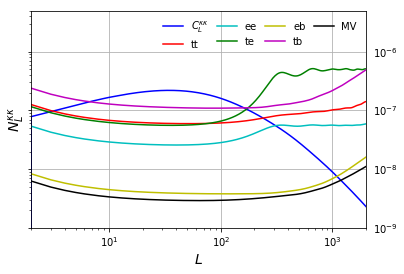

In [14]:
colors=['b','r','c','g','y','m']
plt.figure(figsize=(6,4))
plt.loglog(ll,1./4.*(ll*(ll+1.))**2*cl_phiphi,color=colors[0], label=r'$C_L^{\kappa\kappa}$')
plt.loglog(Ls, 1./4.*(Ls*(Ls+1.))**2.*NL_KK['tt'],color=colors[1],label='tt')
plt.loglog(Ls, 1./4.*(Ls*(Ls + 1.))**2.*NL_KK['ee'],color=colors[2],label='ee')
plt.loglog(Ls, 1./4.*(Ls*(Ls + 1.))**2.*NL_KK['te'],color=colors[3],label='te')
plt.loglog(Ls, 1./4.*(Ls*(Ls + 1.))**2.*NL_KK['eb'],color=colors[4],label='eb')
plt.loglog(Ls, 1./4.*(Ls*(Ls + 1.))**2.*NL_KK['tb'],color=colors[5],label='tb')
plt.loglog(Ls, 1./4.*(Ls*(Ls + 1.))**2.*MV_noise,color='black',label='MV')
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.xlim(2, 2000)
plt.ylim(1e-9,5e-6)
plt.grid()
plt.legend(loc='best',ncol=4,frameon=False, columnspacing=0.8)
plt.xlabel(r'$L$',fontsize=14)
plt.ylabel(r'$N_L^{\kappa\kappa}$',fontsize=14)
plt.savefig(plotpath+'noise_kk_%s_%s_%d_%d%d_%s%s.pdf'%(tag,lmax,l_min,10*noiseUkArcmin,10*thetaFWHMarcmin,no_div,nl_))